# Fashion MNIST with pytorch lightning and neptune.ai

This notebook is accompanying the code on the [repository](https://github.com/jeremyfix/deeplearning-lectures/tree/lightning/LabsSolutions/00-pytorch-FashionMNISTLightning). This is a tutorial for illustrating deep learning training with [pytorch](www.pytorch.org), more specifically the higher level framework [pytorch lightning](https://www.pytorchlightning.ai/). We monitor the training using [neptune.ai](https://app.neptune.ai/).

Several simulations of this code have been executed to fill in a public dashboard on neptune.ai. You can see it at [https://app.neptune.ai/jeremyfix/CamexIA-FashionMNIST/experiments?split=tbl&dash=charts](https://app.neptune.ai/jeremyfix/CamexIA-FashionMNIST/experiments?split=tbl&dash=charts)

In [1]:
%load_ext autoreload
%autoreload 

In [2]:
# If running from google colab, we need to clone the repository and cd to the directory of the tutorial to access the dependency file
!git clone https://gitlab-research.centralesupelec.fr/fix_jer/tp-deeplearning-camexia.git
%cd tp-deeplearning-camexia

Clonage dans 'tp-deeplearning-camexia'...
remote: Enumerating objects: 165, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 165 (delta 3), reused 1 (delta 0), pack-reused 156
Réception d'objets: 100% (165/165), 67.92 Kio | 1.83 Mio/s, fait.
Résolution des deltas: 100% (101/101), fait.
/usr/users/gpu-prof/gpu_fix/GIT/CamexIA/tp-deeplearning-camexia/tp-deeplearning-camexia


In [3]:
# Setup up the environment

# For CPU only
#!pip install -r requirements.txt

# For GPU 
!pip install -r requirements_cuda.txt

Looking in links: https://download.pytorch.org/whl/cu113/torch_stable.html
  Using cached https://download.pytorch.org/whl/cu113/torch-1.10.1%2Bcu113-cp38-cp38-linux_x86_64.whl (1821.4 MB)
  Using cached https://download.pytorch.org/whl/cu113/torchvision-0.11.2%2Bcu113-cp38-cp38-linux_x86_64.whl (24.6 MB)
  Using cached matplotlib-3.1.2-cp38-cp38-manylinux1_x86_64.whl (13.1 MB)
  Using cached neptune_client-0.14.2-py2.py3-none-any.whl
  Using cached torchinfo-1.5.4-py3-none-any.whl (19 kB)
  Using cached tqdm-4.62.3-py2.py3-none-any.whl (76 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 17.0 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 24.8 MB/s eta 0:00:00m eta 0:00:010:01:01
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 14.1 MB/s eta 0:00:00m eta 0:00:01
  Using cached future-0.18.2-py3-none-any.whl
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.7/151.7

  Using cached jsonpointer-2.3-py2.py3-none-any.whl (7.8 kB)
  Using cached fqdn-1.5.1-py3-none-any.whl (9.1 kB)
  Using cached isoduration-20.11.0-py3-none-any.whl (11 kB)
  Using cached rfc3339_validator-0.1.4-py2.py3-none-any.whl (3.5 kB)
  Using cached uri_template-1.2.0-py3-none-any.whl (10 kB)
  Using cached rfc3987-1.3.8-py2.py3-none-any.whl (13 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 1.9 MB/s eta 0:00:00

[notice] A new release of pip available: 22.1.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


## Dataloader illustration

The first step of every deep learning script is to deal with the dataloading. This means writing a [dataset object](https://pytorch.org/docs/stable/data.html#dataset-types) or using already programmed dataset objects and plugging it into a dataloader. A dataloader allows to iterate over the dataset, providing a sequence of mini-batches of data. As we are dealing with images, our dataloader is providing 4D tensor (B, C, H, W) following the pytorh convention of Batch, Channel, Height, Width.

In [4]:
import data
import random
import torch

We first build our dataloaders to see the raw data

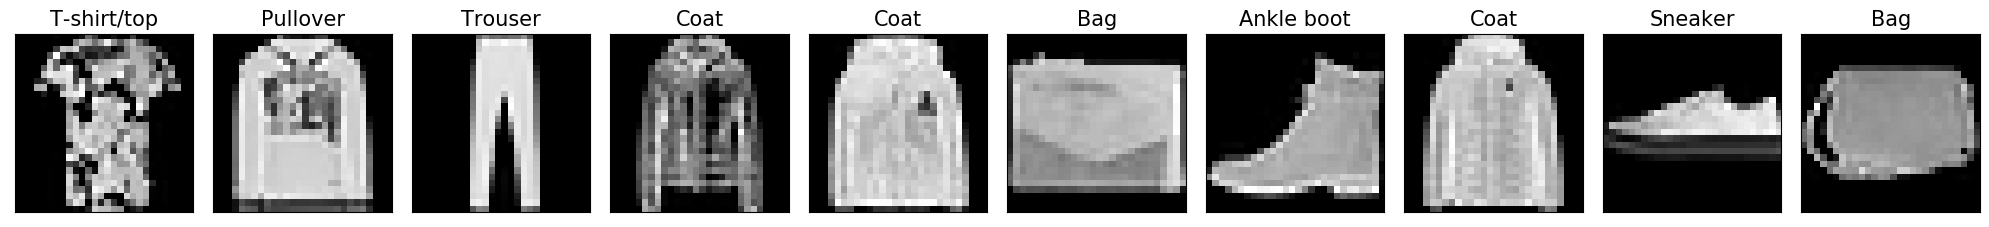

A minibatch of data is a tensor X of shape torch.Size([128, 1, 28, 28]) and y of shape torch.Size([128])


In [5]:
num_threads = 4
valid_ratio = 0.2
batch_size = 128
classes_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal','Shirt', 'Sneaker', 'Bag', 'Ankle boot']

loaders, fnorm = data.make_dataloaders(valid_ratio,
                                  batch_size,
                                  num_threads,
                                  normalize=False,
                                  dataaugment_train=False,
                                  dataset_dir=None,
                                  normalizing_tensor_path=None)
train_loader, valid_loader, test_loader = loaders

data.display_samples(train_loader, 10, 'fashionMNIST_samples.png', classes_names)

X, y = next(iter(train_loader))
print(f"A minibatch of data is a tensor X of shape {X.shape} and y of shape {y.shape}")

And we now play around with data augmentation. Data augmentation is a very important technique for regularization, i.e. generating many variation of your data for which you can also compute the target

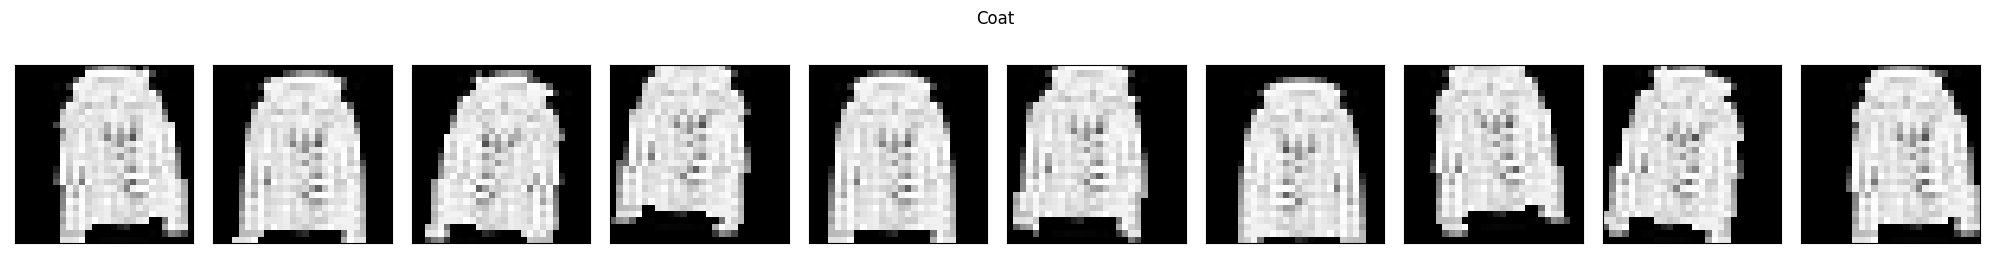

In [6]:
loaders, fnorm = data.make_dataloaders(valid_ratio,
                                  batch_size,
                                  num_threads,
                                  False,
                                  dataaugment_train=True,
                                  dataset_dir=None,
                                  normalizing_tensor_path=None)
# Let us take the first sample of the dataset and sample it several
# times 
train_loader, _, _ = loaders
sample_idx = random.randint(0, len(train_loader.dataset))
samples = [train_loader.dataset[sample_idx][0] for i in range(10)]
label = train_loader.dataset[sample_idx][1] 

# Build a torch tensor from the list of samples
samples = torch.cat(samples, dim=0).unsqueeze(dim=1) # to add C=1

data.display_tensor_samples(samples, label,
                       'fashionMNIST_sample_aug.png',
                        classes_names)

## Training

In [7]:
import train

In [9]:
config = {
    "logdir": "./logs",
    "commit_id": None,
    "dataset_dir": None,
    "num_workers": 2,
    "lr": 0.001,
    "weight_decay": 0.0,
    "dropout": None,
    "data_augment": True, 
    "normalize": True,
    "epochs" : 40,
    "model": "FancyCNN"
}

train.main(config)

Using the device cuda
Logging to ./logs/FancyCNN_1
[Epoch 0/40]


Train Loss : 0.6371, Acc : 0.7663: 100%|█████████████████████████████████████████████████████████████████████▊| 374/375 [00:05<00:00, 65.50it/s]


Valid Loss : 0.9647, Acc : 0.6206
Test  Loss : 0.9975, Acc : 0.6094
>>>>>> Saving a better model <<<<<<<<<
------
[Epoch 1/40]


Train Loss : 0.4164, Acc : 0.8458: 100%|█████████████████████████████████████████████████████████████████████▊| 374/375 [00:05<00:00, 68.35it/s]


Valid Loss : 0.5789, Acc : 0.7987
Test  Loss : 0.5907, Acc : 0.7967
>>>>>> Saving a better model <<<<<<<<<
------
[Epoch 2/40]


Train Loss : 0.3596, Acc : 0.8679: 100%|█████████████████████████████████████████████████████████████████████▊| 374/375 [00:05<00:00, 67.91it/s]


Valid Loss : 0.4904, Acc : 0.8168
Test  Loss : 0.5283, Acc : 0.8086
>>>>>> Saving a better model <<<<<<<<<
------
[Epoch 3/40]


Train Loss : 0.3283, Acc : 0.8797: 100%|█████████████████████████████████████████████████████████████████████▊| 374/375 [00:05<00:00, 67.57it/s]


Valid Loss : 0.3724, Acc : 0.8623
Test  Loss : 0.4058, Acc : 0.8542
>>>>>> Saving a better model <<<<<<<<<
------
[Epoch 4/40]


Train Loss : 0.3055, Acc : 0.8866: 100%|█████████████████████████████████████████████████████████████████████▊| 374/375 [00:05<00:00, 66.77it/s]


Valid Loss : 0.4264, Acc : 0.8402
Test  Loss : 0.4409, Acc : 0.8326
------
[Epoch 5/40]


Train Loss : 0.2856, Acc : 0.8956: 100%|█████████████████████████████████████████████████████████████████████▊| 374/375 [00:05<00:00, 66.76it/s]


Valid Loss : 0.3178, Acc : 0.8855
Test  Loss : 0.3410, Acc : 0.8748
>>>>>> Saving a better model <<<<<<<<<
------
[Epoch 6/40]


Train Loss : 0.2748, Acc : 0.8975: 100%|█████████████████████████████████████████████████████████████████████▊| 374/375 [00:05<00:00, 69.13it/s]


Valid Loss : 0.3556, Acc : 0.8771
Test  Loss : 0.3746, Acc : 0.8635
------
[Epoch 7/40]


Train Loss : 0.2617, Acc : 0.9038: 100%|█████████████████████████████████████████████████████████████████████▊| 374/375 [00:05<00:00, 67.71it/s]


Valid Loss : 0.3872, Acc : 0.8571
Test  Loss : 0.4103, Acc : 0.8486
------
[Epoch 8/40]


Train Loss : 0.2544, Acc : 0.9080: 100%|█████████████████████████████████████████████████████████████████████▊| 374/375 [00:05<00:00, 68.14it/s]


Valid Loss : 0.2983, Acc : 0.8880
Test  Loss : 0.3178, Acc : 0.8811
>>>>>> Saving a better model <<<<<<<<<
------
[Epoch 9/40]


Train Loss : 0.2431, Acc : 0.9102: 100%|█████████████████████████████████████████████████████████████████████▊| 374/375 [00:05<00:00, 68.10it/s]


Valid Loss : 0.2542, Acc : 0.9118
Test  Loss : 0.2656, Acc : 0.9070
>>>>>> Saving a better model <<<<<<<<<
------
[Epoch 10/40]


Train Loss : 0.2184, Acc : 0.9200: 100%|█████████████████████████████████████████████████████████████████████▊| 374/375 [00:05<00:00, 69.02it/s]


Valid Loss : 0.2110, Acc : 0.9243
Test  Loss : 0.2314, Acc : 0.9143
>>>>>> Saving a better model <<<<<<<<<
------
[Epoch 11/40]


Train Loss : 0.2128, Acc : 0.9222: 100%|█████████████████████████████████████████████████████████████████████▊| 374/375 [00:05<00:00, 68.29it/s]


Valid Loss : 0.2625, Acc : 0.9067
Test  Loss : 0.2799, Acc : 0.8989
------
[Epoch 12/40]


Train Loss : 0.2072, Acc : 0.9251: 100%|█████████████████████████████████████████████████████████████████████▊| 374/375 [00:05<00:00, 66.84it/s]


Valid Loss : 0.2972, Acc : 0.8929
Test  Loss : 0.3121, Acc : 0.8882
------
[Epoch 13/40]


Train Loss : 0.2026, Acc : 0.9263: 100%|█████████████████████████████████████████████████████████████████████▊| 374/375 [00:05<00:00, 67.72it/s]


Valid Loss : 0.2855, Acc : 0.8998
Test  Loss : 0.2945, Acc : 0.8992
------
[Epoch 14/40]


Train Loss : 0.1980, Acc : 0.9267: 100%|█████████████████████████████████████████████████████████████████████▊| 374/375 [00:05<00:00, 67.81it/s]


Valid Loss : 0.3165, Acc : 0.8863
Test  Loss : 0.3439, Acc : 0.8784
------
[Epoch 15/40]


Train Loss : 0.1934, Acc : 0.9276: 100%|█████████████████████████████████████████████████████████████████████▊| 374/375 [00:05<00:00, 67.92it/s]


Valid Loss : 0.2013, Acc : 0.9297
Test  Loss : 0.2233, Acc : 0.9181
>>>>>> Saving a better model <<<<<<<<<
------
[Epoch 16/40]


Train Loss : 0.1883, Acc : 0.9313: 100%|█████████████████████████████████████████████████████████████████████▊| 374/375 [00:05<00:00, 68.59it/s]


Valid Loss : 0.2044, Acc : 0.9258
Test  Loss : 0.2243, Acc : 0.9177
------
[Epoch 17/40]


Train Loss : 0.1901, Acc : 0.9298: 100%|█████████████████████████████████████████████████████████████████████▊| 374/375 [00:05<00:00, 67.66it/s]


Valid Loss : 0.2264, Acc : 0.9183
Test  Loss : 0.2429, Acc : 0.9117
------
[Epoch 18/40]


Train Loss : 0.1834, Acc : 0.9324: 100%|█████████████████████████████████████████████████████████████████████▊| 374/375 [00:05<00:00, 70.21it/s]


Valid Loss : 0.2241, Acc : 0.9191
Test  Loss : 0.2437, Acc : 0.9110
------
[Epoch 19/40]


Train Loss : 0.1803, Acc : 0.9334: 100%|█████████████████████████████████████████████████████████████████████▊| 374/375 [00:05<00:00, 67.64it/s]


Valid Loss : 0.2135, Acc : 0.9208
Test  Loss : 0.2285, Acc : 0.9152
------
[Epoch 20/40]


Train Loss : 0.1648, Acc : 0.9394: 100%|█████████████████████████████████████████████████████████████████████▊| 374/375 [00:05<00:00, 67.82it/s]


Valid Loss : 0.2147, Acc : 0.9208
Test  Loss : 0.2374, Acc : 0.9121
------
[Epoch 21/40]


Train Loss : 0.1619, Acc : 0.9400: 100%|█████████████████████████████████████████████████████████████████████▊| 374/375 [00:05<00:00, 67.62it/s]


Valid Loss : 0.2115, Acc : 0.9246
Test  Loss : 0.2309, Acc : 0.9161
------
[Epoch 22/40]


Train Loss : 0.1622, Acc : 0.9393: 100%|█████████████████████████████████████████████████████████████████████▊| 374/375 [00:05<00:00, 67.67it/s]


Valid Loss : 0.2229, Acc : 0.9210
Test  Loss : 0.2471, Acc : 0.9097
------
[Epoch 23/40]


Train Loss : 0.1571, Acc : 0.9427: 100%|█████████████████████████████████████████████████████████████████████▊| 374/375 [00:05<00:00, 68.23it/s]


Valid Loss : 0.1946, Acc : 0.9280
Test  Loss : 0.2129, Acc : 0.9209
>>>>>> Saving a better model <<<<<<<<<
------
[Epoch 24/40]


Train Loss : 0.1545, Acc : 0.9432: 100%|█████████████████████████████████████████████████████████████████████▊| 374/375 [00:05<00:00, 69.83it/s]


Valid Loss : 0.2159, Acc : 0.9228
Test  Loss : 0.2383, Acc : 0.9112
------
[Epoch 25/40]


Train Loss : 0.1525, Acc : 0.9440: 100%|█████████████████████████████████████████████████████████████████████▊| 374/375 [00:05<00:00, 70.01it/s]


Valid Loss : 0.2017, Acc : 0.9287
Test  Loss : 0.2266, Acc : 0.9202
------
[Epoch 26/40]


Train Loss : 0.1501, Acc : 0.9454: 100%|█████████████████████████████████████████████████████████████████████▊| 374/375 [00:05<00:00, 66.71it/s]


Valid Loss : 0.2118, Acc : 0.9221
Test  Loss : 0.2280, Acc : 0.9134
------
[Epoch 27/40]


Train Loss : 0.1504, Acc : 0.9440: 100%|█████████████████████████████████████████████████████████████████████▊| 374/375 [00:05<00:00, 68.36it/s]


Valid Loss : 0.2165, Acc : 0.9250
Test  Loss : 0.2334, Acc : 0.9167
------
[Epoch 28/40]


Train Loss : 0.1485, Acc : 0.9464: 100%|█████████████████████████████████████████████████████████████████████▊| 374/375 [00:05<00:00, 68.45it/s]


Valid Loss : 0.2077, Acc : 0.9243
Test  Loss : 0.2288, Acc : 0.9139
------
[Epoch 29/40]


Train Loss : 0.1474, Acc : 0.9457: 100%|█████████████████████████████████████████████████████████████████████▊| 374/375 [00:05<00:00, 67.49it/s]


Valid Loss : 0.2149, Acc : 0.9258
Test  Loss : 0.2346, Acc : 0.9155
------
[Epoch 30/40]


Train Loss : 0.1379, Acc : 0.9496: 100%|█████████████████████████████████████████████████████████████████████▊| 374/375 [00:05<00:00, 68.53it/s]


Valid Loss : 0.1978, Acc : 0.9293
Test  Loss : 0.2156, Acc : 0.9196
------
[Epoch 31/40]


Train Loss : 0.1349, Acc : 0.9518: 100%|█████████████████████████████████████████████████████████████████████▊| 374/375 [00:05<00:00, 68.89it/s]


Valid Loss : 0.1823, Acc : 0.9358
Test  Loss : 0.2015, Acc : 0.9271
>>>>>> Saving a better model <<<<<<<<<
------
[Epoch 32/40]


Train Loss : 0.1333, Acc : 0.9520: 100%|█████████████████████████████████████████████████████████████████████▊| 374/375 [00:05<00:00, 68.41it/s]


Valid Loss : 0.1773, Acc : 0.9377
Test  Loss : 0.1947, Acc : 0.9308
>>>>>> Saving a better model <<<<<<<<<
------
[Epoch 33/40]


Train Loss : 0.1322, Acc : 0.9519: 100%|█████████████████████████████████████████████████████████████████████▊| 374/375 [00:05<00:00, 68.28it/s]


Valid Loss : 0.2074, Acc : 0.9266
Test  Loss : 0.2251, Acc : 0.9173
------
[Epoch 34/40]


Train Loss : 0.1320, Acc : 0.9523: 100%|█████████████████████████████████████████████████████████████████████▊| 374/375 [00:05<00:00, 69.54it/s]


Valid Loss : 0.1947, Acc : 0.9291
Test  Loss : 0.2150, Acc : 0.9205
------
[Epoch 35/40]


Train Loss : 0.1308, Acc : 0.9521: 100%|█████████████████████████████████████████████████████████████████████▊| 374/375 [00:05<00:00, 66.31it/s]


Valid Loss : 0.1831, Acc : 0.9334
Test  Loss : 0.1992, Acc : 0.9279
------
[Epoch 36/40]


Train Loss : 0.1289, Acc : 0.9525: 100%|█████████████████████████████████████████████████████████████████████▊| 374/375 [00:05<00:00, 70.37it/s]


Valid Loss : 0.1855, Acc : 0.9328
Test  Loss : 0.2023, Acc : 0.9262
------
[Epoch 37/40]


Train Loss : 0.1288, Acc : 0.9521: 100%|█████████████████████████████████████████████████████████████████████▊| 374/375 [00:05<00:00, 68.83it/s]


Valid Loss : 0.1757, Acc : 0.9377
Test  Loss : 0.1967, Acc : 0.9292
>>>>>> Saving a better model <<<<<<<<<
------
[Epoch 38/40]


Train Loss : 0.1258, Acc : 0.9540: 100%|█████████████████████████████████████████████████████████████████████▊| 374/375 [00:05<00:00, 69.03it/s]


Valid Loss : 0.1944, Acc : 0.9317
Test  Loss : 0.2156, Acc : 0.9215
------
[Epoch 39/40]


Train Loss : 0.1270, Acc : 0.9533: 100%|█████████████████████████████████████████████████████████████████████▊| 374/375 [00:05<00:00, 68.17it/s]


Valid Loss : 0.1876, Acc : 0.9337
Test  Loss : 0.2096, Acc : 0.9253
------
